[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/AmineDiro/OT-GAN/blob/main/OT%20project.ipynb#scrollTo=66I2N56tuMq9)

In [11]:
import os
import matplotlib.pyplot as plt
import matplotlib.animation as animation

import numpy as np
import torch
import torchvision
from torchvision import datasets, transforms
from torch.utils.data import SubsetRandomSampler,Subset
from torchvision.utils import save_image
import torch.nn as nn
from torch import Tensor
import torch.nn.functional as F
import torch.optim as optim

import torchvision.utils as vutils
from torch.utils.data import DataLoader
from torch.autograd import Variable
from tqdm.auto import tqdm
import ot
#import ot
%load_ext autoreload
%autoreload 2
%reload_ext autoreload


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [4]:
from Generator import Generator
from Discriminator import Discriminator 
from utils import *

In [13]:
torch.cuda.empty_cache()

In [5]:
# Parametres

batch_size=64 # selon les auteurs mais on va pas utiliser ça
ginput_dim = 100

#val_batch_size=128
n_epochs=20
lr=3e-4
beta1= 0.5
beta2=0.999
epsilon=1
n_gen=3 #nupmber of generator updates / discriminator update

output_path_imgs ="./generated_image"
save_epoch = 2
sample_interval = 2

In [6]:
use_cuda =True
# Init device 
print("CUDA Available: ",torch.cuda.is_available())
device = torch.device("cuda" if (use_cuda and torch.cuda.is_available()) else "cpu")

CUDA Available:  True


In [7]:

transform = transforms.Compose([transforms.Grayscale(3) ,transforms.Resize(size=(32, 32)), transforms.ToTensor()])

trainset = torchvision.datasets.MNIST(root='./data_mnist', train=True,
                                        download=False, transform=transform)
#trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
#                                          shuffle=True, num_workers=4)

indices = torch.randperm(len(trainset))[:2000]
subset_train_dataset = Subset(trainset, indices)
trainloader = torch.utils.data.DataLoader(subset_train_dataset, batch_size=batch_size,
                                          shuffle=True, num_workers=0)

In [8]:
#Create Generator
gmodel = Generator().to(device)
# Create the discriminator.
dmodel = Discriminator().to(device)

In [12]:
optimizer_D = optim.Adam(dmodel.parameters(), lr=lr, betas=[beta1,beta2])
optimizer_G = optim.Adam(gmodel.parameters(), lr=lr,betas=[beta1,beta2])

mone = -torch.tensor(1, dtype=torch.float).to(device)
G_losses=[]
D_losses=[]

for epoch in range(n_epochs):
    b_done =0
    for t in range(len(trainloader)//2):    
        optimizer_D.zero_grad()
        optimizer_G.zero_grad()
        noise = ((torch.rand([batch_size, ginput_dim])*-2)+1).to(device)
        prime_noise = ((torch.rand([batch_size, ginput_dim])*-2)+1).to(device)
        gen_img = Variable(gmodel(noise),requires_grad=False)
        gen_img_prime = Variable(gmodel(prime_noise),requires_grad=False)
        Y , Yprime = dmodel(gen_img), dmodel(gen_img_prime)

        #real data in X
        sample1 , _ = next(iter(trainloader))
        sample2 , _ = next(iter(trainloader))

        X = dmodel(sample1.to(device))
        Xprime = dmodel(sample2.to(device))

        loss, loss_generator, loss_critic = loss_func(X, Xprime, Y, Yprime)
        G_losses.append(loss_generator)
        D_losses.append(loss_critic)

        if (t+1)%n_gen == 0 :
            #loss = -loss
            loss.backward(mone)
            optimizer_D.step()
        else :
            optimizer_G.zero_grad()
            loss.backward()
            optimizer_G.step()
        b_done +=1
        print("[Epoch {}/{}] [Batch {}/{}] [G loss: {}] [D loss: {}]".format(epoch, 
                                                                n_epochs, 
                                                                b_done , 
                                                                len(trainloader)//2, 
                                                                loss_generator.item(),
                                                                loss_critic.item()))
    #if epoch%sample_interval==0:
        save_image(gen_img.data[:64], os.path.join(output_path_imgs, "epoch_{}.png".format(epoch)), 
                       nrow=8, normalize=True)
    
    if epoch % save_epoch == 0:
        torch.save({
            'generator' : gmodel.state_dict(),
            'critic' : dmodel.state_dict(),
            'optimizer_G' : optimizer_G.state_dict(),
            'optimizerD' : optimizer_D.state_dict(),
            }, 'model/model_epoch_{}.pth'.format(epoch))

[Epoch 0/20] [Batch 1/16] [G loss: 0.34411540627479553] [D loss: 3.9434518814086914]
[Epoch 0/20] [Batch 2/16] [G loss: 0.34515851736068726] [D loss: 3.9460136890411377]
[Epoch 0/20] [Batch 3/16] [G loss: 0.34672659635543823] [D loss: 3.9481465816497803]
[Epoch 0/20] [Batch 4/16] [G loss: 3.556034803390503] [D loss: 3.931727647781372]
[Epoch 0/20] [Batch 5/16] [G loss: 3.569432258605957] [D loss: 3.9221582412719727]
[Epoch 0/20] [Batch 6/16] [G loss: 3.592372179031372] [D loss: 3.9235968589782715]
[Epoch 0/20] [Batch 7/16] [G loss: 2.326150417327881] [D loss: 3.9096624851226807]
[Epoch 0/20] [Batch 8/16] [G loss: 2.268232583999634] [D loss: 3.9220941066741943]
[Epoch 0/20] [Batch 9/16] [G loss: 2.3042876720428467] [D loss: 3.9130570888519287]
[Epoch 0/20] [Batch 10/16] [G loss: 0.1510138213634491] [D loss: 3.9504261016845703]
[Epoch 0/20] [Batch 11/16] [G loss: 0.15158462524414062] [D loss: 3.9491140842437744]
[Epoch 0/20] [Batch 12/16] [G loss: 0.1451966017484665] [D loss: 3.957119464

RuntimeError: DataLoader worker (pid(s) 8956, 17556, 19632) exited unexpectedly

--- 

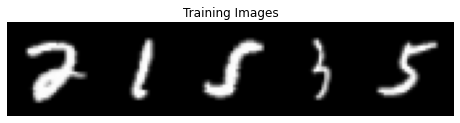

In [64]:
# Plot the training images.
sample_batch = next(iter(trainloader))
plt.figure(figsize=(8, 8))
plt.axis("off")
plt.title("Training Images")
plt.imshow(np.transpose(vutils.make_grid(
    sample_batch[0].to(device)[ : 64], padding=2, normalize=True).cpu(), (1, 2, 0)))

plt.show()

## Testing loss

In [61]:
# Plot the training images.
def plot_generated_images(sample_batch, epoch):
    fig, ax = plt.subplots(figsize=(8, 8))
    ax.axis("off")
    ax.set_title("Generate Image for epoch {:d}".format(epoch))
    ax.imshow(np.transpose(vutils.make_grid(
        sample_batch[0].to(device)[ : 64], padding=2, normalize=True).cpu(), (1, 2, 0)))    
    plt.show()

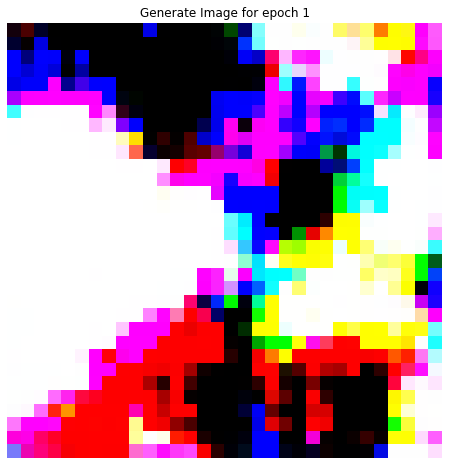

In [66]:
noise = ((torch.rand([batch_size, ginput_dim])*-2)+1).to(device)
sample_batch = gmodel(noise)
plot_generated_images(sample_batch, 1)